# Exercise 01
 I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Load Data

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
print(f"{len(words)=}")

len(words)=32033


## Helpers

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Build Dataset

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Pytorch Layers: Linear & Batch-norm implementation

In [6]:
class Linear:
    def __init__(self, fan_in:int, fan_out:int, _generator:torch.Generator, bias:bool = True) -> None:
        self.W = torch.randn((fan_in,fan_out), generator=_generator) / fan_in**0.5
        self.b = torch.randn(fan_out, generator=_generator) if bias else None

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.b is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with back-prop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running-momentum update)
        self._running_mean = torch.zeros(dim)
        self._running_var = torch.ones(dim)

    def __call__(self, x):
        # forward-pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch var
        else:
            xmean = self._running_mean
            xvar = self._running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalization  of batch
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self._running_mean = (1-self.momentum) * self._running_mean + self.momentum * xmean
                self._running_var = (1-self.momentum) * self._running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

## Deep Multi Layer Perceptron Model

In [79]:
vocab_size = 27
# block_size = 3
n_embed = 10 # dimensions of embedding
n_hidden = 100 # number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size,  n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(         n_hidden,   vocab_size, g)
]

# initializations
with torch.no_grad():
    # make last layer weights and bias to 0
    layers[-1].W *= 0  
    layers[-1].b *= 0
    # apply kaiming init to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 0 # initializing Weights to 0
            layer.b *= 0 # initializing bias to 0

parameters = [C] + [p  for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set requries grad flag
for p in parameters:
    p.requires_grad = True

46497


In [80]:
for i,layer in enumerate((layers)):
    if isinstance(layer, Linear):
        print(layers[i].W.sum(), layers[i].b.sum())

tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)


## Training

In [81]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini-batch
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # learning rate with decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/(p.data.std() + 1e-5)).log10().item()  for p in parameters])

    if i == 1:
        break

      0/ 200000:3.295837


In [82]:
x.sum()

tensor(4.7195e-07, grad_fn=<SumBackward0>)

In [83]:
for i,layer in enumerate((layers)):
    if isinstance(layer, Linear):
        print(layers[i].W.sum(), layers[i].b.sum())

tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>) tensor(2.0489e-08, grad_fn=<SumBackward0>)


## Visualize the Activations

layer  1 (Tanh      ): mean +0.00, std 0.00, saturate: 0.00%
layer  3 (Tanh      ): mean +0.00, std 0.00, saturate: 0.00%
layer  5 (Tanh      ): mean +0.00, std 0.00, saturate: 0.00%
layer  7 (Tanh      ): mean +0.00, std 0.00, saturate: 0.00%
layer  9 (Tanh      ): mean +0.00, std 0.00, saturate: 0.00%


Text(0.5, 1.0, 'activation distribution')

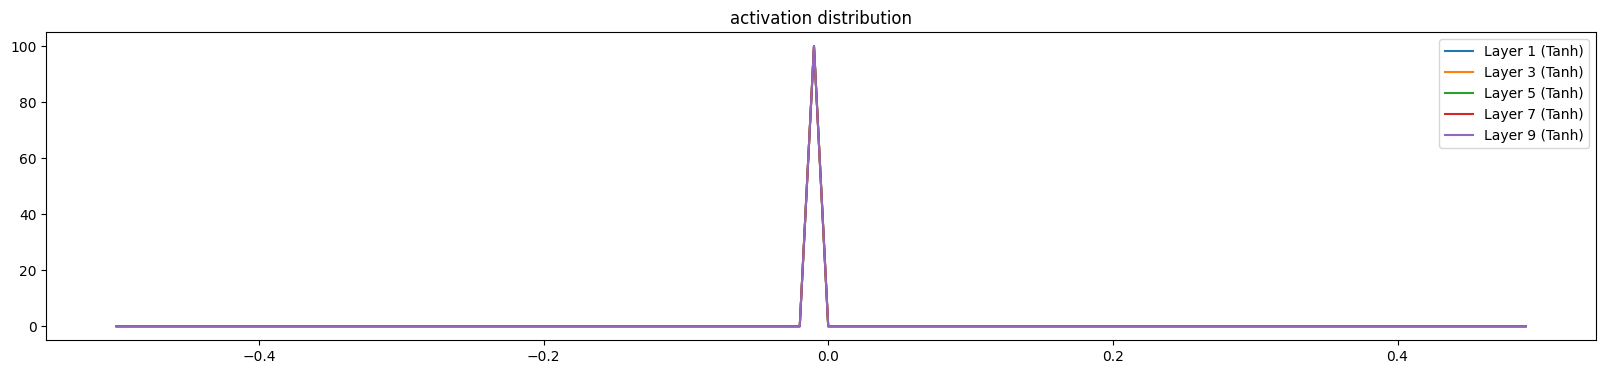

In [19]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note exclude the ouptut layer
    if isinstance(layer, Tanh):
        t = layer.out
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturate: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print(f"layer {i:2d} ({layer.__class__.__name__:10s}): mean {t.mean():+.2f}, std {t.std():.2f}, saturate: {(t.abs()>0.97).float().mean()*100:.2f}%")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

## Visualize Gradients

layer  1 (Tanh      ): mean +0.000000, std 0.000000e+00
layer  3 (Tanh      ): mean +0.000000, std 0.000000e+00
layer  5 (Tanh      ): mean +0.000000, std 0.000000e+00
layer  7 (Tanh      ): mean +0.000000, std 0.000000e+00
layer  9 (Tanh      ): mean +0.000000, std 0.000000e+00


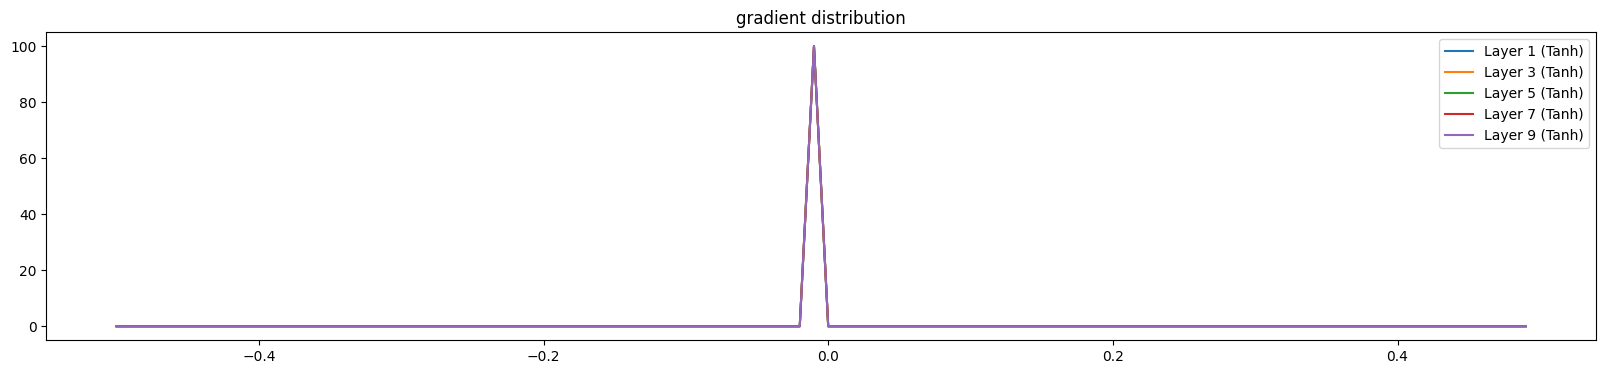

In [22]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note exclude the ouptut layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturate: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print(f"layer {i:2d} ({layer.__class__.__name__:10s}): mean {t.mean():+f}, std {t.std():e}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution');

## Visualize Weight Gradients

weight (27, 10)   | mean +0.000000, std 0.000000e+00 | grad:data 0.0
weight (30, 100)  | mean +0.000000, std 0.000000e+00 | grad:data nan
weight (100, 100) | mean +0.000000, std 0.000000e+00 | grad:data nan
weight (100, 100) | mean +0.000000, std 0.000000e+00 | grad:data nan
weight (100, 100) | mean +0.000000, std 0.000000e+00 | grad:data nan
weight (100, 100) | mean +0.000000, std 0.000000e+00 | grad:data nan
weight (100, 27)  | mean +0.000000, std 0.000000e+00 | grad:data nan


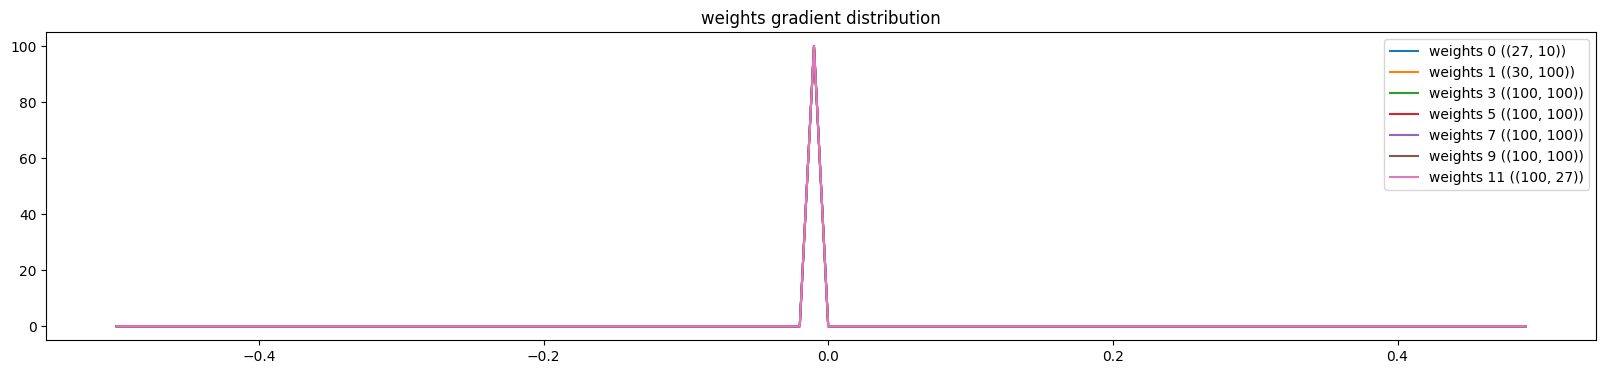

In [40]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {str(tuple(p.shape)):10s} | mean {t.mean():+f}, std {t.std():e} | grad:data {t.std()/p.std()}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'weights {i} ({tuple(p.shape)})')

plt.legend(legends)
plt.title('weights gradient distribution');

## Update to data distribution

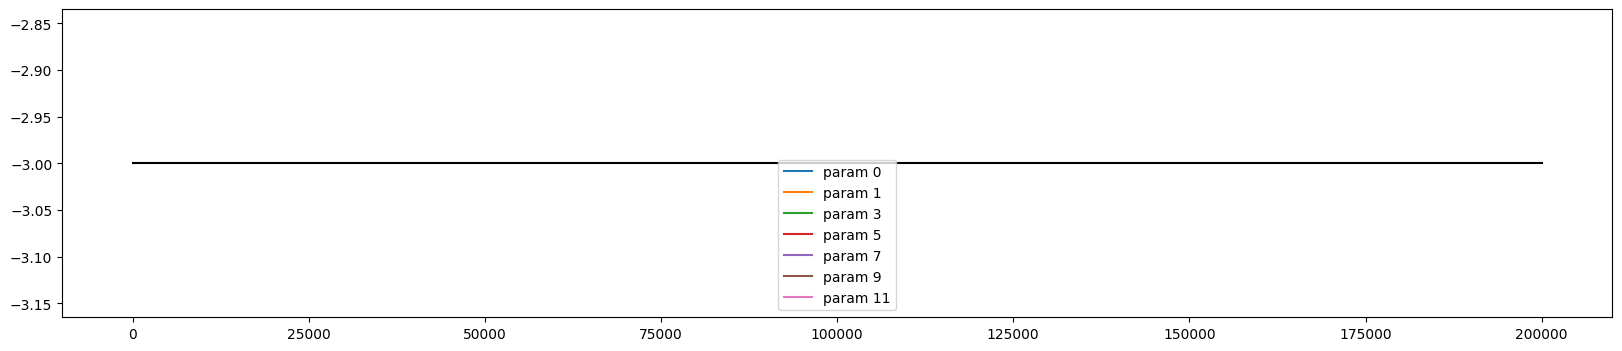

In [42]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 
plt.legend(legends);

In [43]:
ud[0]

[-inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -0.0010002717608585954]

## Conclusion

The loss of model is close to an untrained/unconfident model ~3.29. The Distribution of activations and gradients plots shows that neurons are dead (not activated) and does not undergo any training. Other than bias at the output layer there is no training happending in the neural network